# NB2: Choosing and Training a Model

In the previous notebook, we saw how we can perform an initial analysis of our data and explored various ways of transforming that data. We are ready now to choose a model and start training that model. We will explore a few common machine learning models as well as as some ways to help improve our predictions. We will be using a box emulator model to evaluate the accuracy of our predictions.

## Box Emulator Model
This model takes one timestep of initial conditions to feed the machine learning model we built. It then predicts one timestep, and uses the prediction as the input for another prediction (along with the static environmental variables), and so forth for *n* timesteps. In actual practice, the environmental variables from the climate model would be varying as well, but we use a variety of experiments with variable enviromental factors to learn from and simplify the process. 

We can compare the model with actual GECKO-A generated data to return a variety of performance metrics and assess our model.


## About the data

The data have been processed slightly and separated into training and validation sets. There are two sets available. There is the binned set that we were working with in the previous notebook and the aggregated set. In the binned set the gas and aersol components are separated by volatility. In the aggregated set the have been narrowed down to a single feature for each component by summing their parts. We will be working with the aggregated data in this notebook. 

## Data
 **Data generation procedure**: The machine-learning training dataset in this project (or library) is generated by the hyper-explicit chemical mechanism, GECKO-A. This library consists of results from thousands of GECKO-A simulations under vastly different conditions. More information about GECKO-A can be found [here](https://www2.acom.ucar.edu/modeling/gecko). Each model run lasts 5 simulation days.
 
 ### Potential Input Variables
* Temperature (K): The temperature at which the GECKO-A experiments were conducted. Temperature will affect the reaction rates of many reactions. It also affects the partitioning of a given compound between the gas-phase and particle-phase.
* Solar zenith angle (degree): The solar zenith angle at which the GECKO-A experiments were conducted. This will affect the photolysis reactions. 
* Pre-existing aerosols (micrograms per cubic meter): Depending on the environmental conditions (e.g., temperature) and the vapor pressure, a compound can deposit onto (pre-existing) aerosols or evaporate from the aerosols. 
* NOx (ppb): concentration of nitrogen oxides. These are important compounds in the atmosphere, affecting the chemical mechanisms of many volatile organic compounds.
* O3 (ppb): concentration of ozone. It’s another important compounds in the atmosphere, affecting the chemical mechanisms of many VOCs.
* OH (10^6 molecules per cubic centimeter): concentration of hydroxyl radicals (OH). It’s one of the most important oxidants in the atmosphere, largely driving the oxidation of many VOCs.

### Output Variables
* Precursor (micrograms per cubic meter): time series of the VOC precursor. We call it “precursor” because it’ll undergo chemical reactions and produce other compounds.
* Gas (micrograms per cubic meter): mass concentration of products in the gas-phase.
* Aerosol (micrograms per cubic meter): mass concentration of products in the aerosol-phase.

### Metadata

| Metadata | Units | Label | 
| ------------- | :----:|:----------- | 
| Number Experiments   | 2000     | id | 
| Total Timesteps   | 1440     | Time |
| Timestep Delta   | 300 seconds | - |


### Potential Input Variables

| Variable Name | Units | Type | 
| ------------- | :----:|:----------- | 
| Precursor  | ug/m3     | Varies | 
| Gas   | ug/m3     | Varies   |
| Aerosol   | ug/m3     | Varies |
| Temperature   | K     | Static         |
| Solar Zenith Angle   | degree     | Static        |
| Pre-existing Aersols   | ug/m3     | Static         |
| o3  | ppb     | Static         |
| nox   | ppb     | Static         |
| oh   | 10^6 molec/cm3     | Static         |

### Potential Output Variables

| Variable Name | Units | Type | 
| ------------- | :----:|:----------- | 
| Precursor (at t+1) | ug/m3     | Varies | 
| Gas   (at t+1)  | ug/m3   | Varies   |
| Aerosol (at t+1)  | ug/m3     | Varies |


### What is the question we are trying to answer and how is the data separated to help us answer that question?

We are interested in developing a model that predicts precursor, gas, and aersol quantities at t = t + n. This would allow us to develop an emulator for the GECKO-A mechanism that is less computationally expensive. The data have been separated into input and output sets where the input is at time step t and the output is at t + 1. After we train a model, we will be able to run a simulator based on that model that takes the initital conditions we supply and generates a timeseries of predictions. We can then compare that timeseries of predictions to the truth to determine the accuracy of our model. 

### Training, validation, and testing sets
The training dataset/library consists of 2000 GECKO experiments, including results for 5 day runs (1440 timesteps at 300 second intervals). The data has already been split into training/validation sets by experiments of size 1600 and 200. There are 1440 - 1 rows for each set because of how the data is mapped. Thus, the training set consists of 2,302,400 samples of data and validation set with 287,800 samples.

** Basic decision tree before random forest** 

In [1]:
# !pip install git+https://github.com/NCAR/gecko-ml.git

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import yaml
import copy
import torch
import pickle
import logging
import traceback
import numpy as np
import pandas as pd
import tensorflow as tf
import multiprocessing as mp
import matplotlib.pyplot as plt
import s3fs
import compare_models
from sklearn.linear_model import LinearRegression
from helpers import *


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
sys.path.append("/glade/work/schreck/repos/GECKO_OPT/clean/gecko-ml")
# from geckoml.models import DenseNeuralNetwork, GRUNet
from geckoml.metrics import *
from geckoml.data import *
#from geckoml.box import *

from scipy.stats import pearsonr
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
%matplotlib inline

In [2]:
# create AWS file system object
fs = s3fs.S3FileSystem(anon=True)

In [3]:
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]

In [4]:
def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

In [5]:
# This is a transformation class that simply returns the data. 
class IdentityTransformer(TransformerMixin,BaseEstimator):    
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array.to_numpy()
    
    def inverse_transform(self,X, copy=None):
        return X

```
def log_transform_safely(dataFrame, column_names, min_value):
    """
        Performs log transform but sets any value that is negative infinty to a set min_value.
    """
    transformed = log_transform(dataFrame, column_names)
    negatives = transformed[column_names] == np.NINF
    try:
        for column in negatives.columns:
            transformed.loc[negatives[column], column] = min_value
    except:
        transformed.loc[negatives, column_names] = min_value
    return transformed```

### Load and view the data. 

The data is publically available via AWS. We will be working with the aggregated toluene set. There is other sets available that can be viewed using the following: 
```
for file in fs.ls("ncar-aiml-data-commons/gecko/")[1:]:
    print(file)
```

After you load the data show the first 5 entries and plot a histogram of all the data not including time or id.

In [6]:
train_in = fetch_data('ncar-aiml-data-commons/gecko/toluene_train_in_agg.parquet')
train_out = fetch_data('ncar-aiml-data-commons/gecko/toluene_train_out_agg.parquet')
val_in = fetch_data('ncar-aiml-data-commons/gecko/toluene_val_in_agg.parquet')
val_out = fetch_data('ncar-aiml-data-commons/gecko/toluene_val_out_agg.parquet')

In [7]:
train_in.head(5)

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
0,1.000000,0.037689,0.000000,0.000000e+00,305.065364,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
1,301.207794,0.037426,0.000494,3.058167e-11,304.978044,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
2,601.415588,0.037164,0.000981,1.193708e-10,304.890766,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
3,901.623352,0.036904,0.001459,2.814293e-10,304.803571,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
4,1201.831177,0.036646,0.001929,5.148522e-10,304.716502,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0


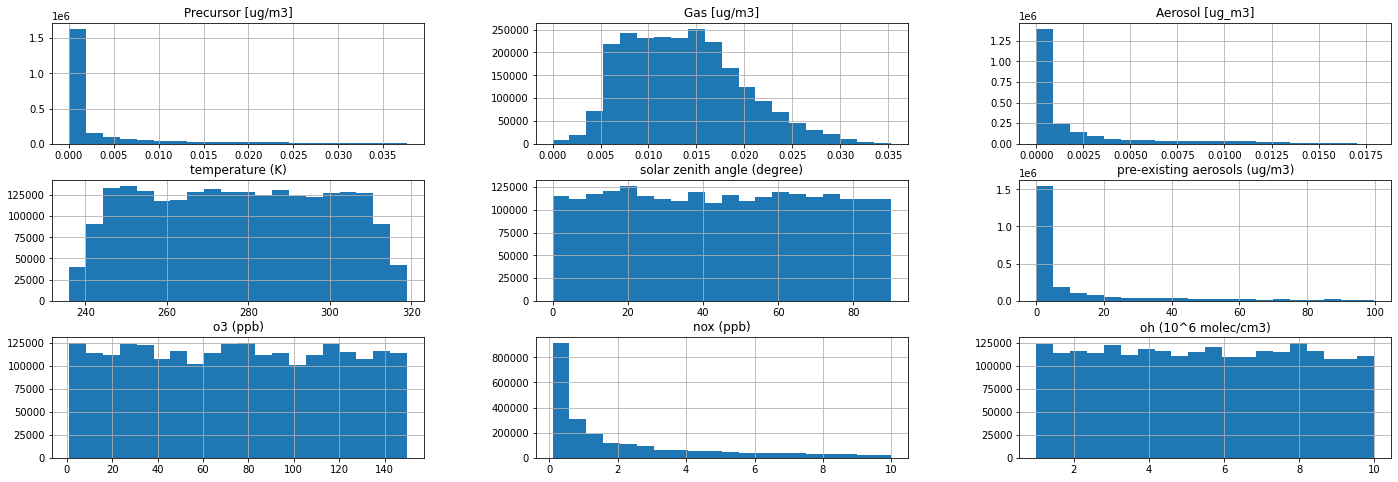

In [8]:
_ = train_in.drop(['Time [s]', 'id'], axis=1).hist(bins=20 ,figsize=(24,8))

### Our first model

We will call on some of the skills we learned in the the previous notebook to transform the data in a manner that improves our predictions. We will process the data first in the following manner to prepare for training a model:

* Apply Min Max scaler to fit the data to fall between 1e-12 and 1. 

* Perform Log transform of 'Precursor [ug/m3]', 'Aerosol [ug_m3]','pre-existing aerosols (ug/m3)', 'nox (ppb)'

* Apply a z-score scaler


## Linear Regression

[Linear regression](https://towardsdatascience.com/linear-regression-detailed-view-ea73175f6e86) assumes a linear relationship between input and output and attempts to fit such a model by finding the lowest cost to fitting. Linear regression is a good baseline model. We will first fit the model without performing any scaling. 

### Setup the data

There are a couple steps needed to prep the data for experiment. The cell below defines a few parameters needed later. Next we apply a scaler. We aren't scaling the data yet so we can just use an IdentityTransformer() function which just returns data. Finally we batch the data into sets to make it faster to process.

In [9]:
species = 'toluene'
bin_prefix = ['Gas [ug/m3]', 'Aerosol [ug_m3]']
input_vars = ['Time [s]', 'Precursor [ug/m3]', 'Gas [ug/m3]', 
              'Aerosol [ug_m3]', 'temperature (K)', 'solar zenith angle (degree)', 
              'pre-existing aerosols (ug/m3)', 'o3 (ppb)', 'nox (ppb)', 'oh (10^6 molec/cm3)', 'id']
output_vars = ['Time [s]', 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]', 'id']
seq_length = 20
ensemble_members = 1
seed = 8886
num_timesteps = train_in['Time [s]'].nunique()

In [10]:
# Rescale training and validation / testing data
X_scaler = IdentityTransformer()
scaled_train_in = X_scaler.fit_transform(train_in.drop(['Time [s]', 'id'], axis=1))
scaled_val_in = X_scaler.transform(val_in.drop(['Time [s]', 'id'], axis=1))

y_scaler = IdentityTransformer()
scaled_train_out = y_scaler.transform(train_out.drop(['Time [s]', 'id'], axis=1))
scaled_val_out = y_scaler.transform(val_out.drop(['Time [s]', 'id'], axis=1))

In [11]:
# Batch the training experiments 
#logging.info("Batching the training data by experiment, this may take a few minutes")
def work(exp):
    in_data = X_scaler.transform(train_in[train_in['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))
train_exps = list(train_in['id'].unique())
with mp.Pool(processes=16) as p:
    in_array, env_array = zip(*[result for result in tqdm.tqdm(p.imap(work, train_exps), total=len(train_exps))])
#in_array, env_array = zip(*[work(x) for x in train_exps])
in_array = np.concatenate(in_array) # (num_experiments, num_timesteps, outputs)
env_array = np.concatenate(env_array)

tqdm.tqdm._instances.clear()

#logging.info("Batching the validation data by experiment")
def work(exp):
    in_data = X_scaler.transform(val_in[val_in['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))
val_exps = list(val_in['id'].unique())
val_in_array, val_env_array = zip(*[work(x) for x in tqdm.tqdm(val_exps)])
val_in_array = np.concatenate(val_in_array) # (num_experiments, num_timesteps, outputs)
val_env_array = np.concatenate(val_env_array)

100%|██████████| 200/200 [00:02<00:00, 68.35it/s]


### Train Linear Regression model and validate it using the box model validator

In [12]:
lin_model = LinearRegression()
lin_model.fit(scaled_train_in, scaled_train_out)

LinearRegression()

In [13]:
lin_mae, truth, preds, failed_exps = compare_models.box_val(
    lin_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    output_vars, 
    val_out
)

100%|██████████| 1438/1438 [00:00<00:00, 15162.14it/s]


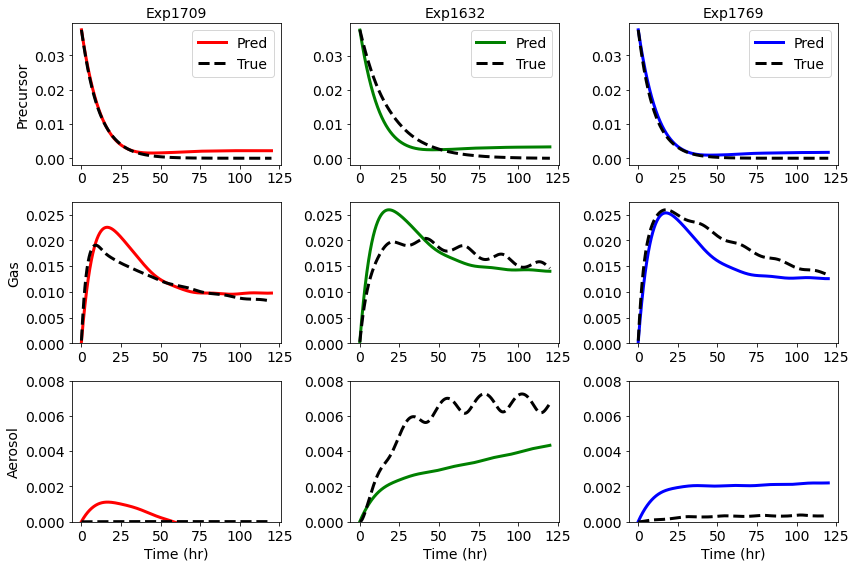

In [14]:
prec_lim = 0.05
gas_lim = 0.0275
aero_lim = 0.008
compare_models.plot(truth, preds, 14, prec_lim, gas_lim, aero_lim)

In [15]:
get_metrics(truth,preds)

Precursor [ug/m3] - R2: 0.92 Pearson: 0.98
Gas [ug/m3] - R2: 0.92 Pearson: 0.96
Aerosol [ug_m3] - R2: -345.65 Pearson: -0.36


{'Precursor [ug/m3]': [0.9199718776706232, 0.9757180193138004],
 'Gas [ug/m3]': [0.9243868667485071, 0.9631437147065423],
 'Aerosol [ug_m3]': [-345.6470712063888, -0.3550234575582784]}

Without any scaling we get results that somewhat approximate the truth for Precursor and Gas. The prediction for Aerosol was not even close though. 

### Transform the data

Here 

In [16]:
train_in = fetch_data('ncar-aiml-data-commons/gecko/toluene_train_in_agg.parquet')
train_out = fetch_data('ncar-aiml-data-commons/gecko/toluene_train_out_agg.parquet')
val_in = fetch_data('ncar-aiml-data-commons/gecko/toluene_val_in_agg.parquet')
val_out = fetch_data('ncar-aiml-data-commons/gecko/toluene_val_out_agg.parquet')

In [17]:
train_in_log = log_transform_safely(train_in, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'], -12)
train_out_log = log_transform_safely(train_out, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'], -12)
val_in_log = log_transform_safely(val_in, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'], -12)
val_out_log = log_transform_safely(val_out, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'], -12)

In [18]:
# Rescale training and validation / testing data
X_scaler = MinMaxScaler((-1,1)).fit(train_in_log.drop(['Time [s]', 'id'], axis=1))
scaled_train_in = X_scaler.fit_transform(train_in_log.drop(['Time [s]', 'id'], axis=1))
scaled_val_in = X_scaler.transform(val_in_log.drop(['Time [s]', 'id'], axis=1))

y_scaler = get_output_scaler(X_scaler, [0,1,2], 'MinMaxScaler')
scaled_train_out = y_scaler.transform(train_out_log.drop(['Time [s]', 'id'], axis=1))
scaled_val_out = y_scaler.transform(val_out_log.drop(['Time [s]', 'id'], axis=1))

In [19]:
# Batch the training experiments 
#logging.info("Batching the training data by experiment, this may take a few minutes")
def work(exp):
    in_data = X_scaler.transform(train_in[train_in['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))
train_exps = list(train_in['id'].unique())
with mp.Pool(processes=16) as p:
    in_array, env_array = zip(*[result for result in tqdm.tqdm(p.imap(work, train_exps), total=len(train_exps))])
#in_array, env_array = zip(*[work(x) for x in train_exps])
in_array = np.concatenate(in_array) # (num_experiments, num_timesteps, outputs)
env_array = np.concatenate(env_array)

tqdm.tqdm._instances.clear()

#logging.info("Batching the validation data by experiment")
def work(exp):
    in_data = X_scaler.transform(val_in[val_in['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))
val_exps = list(val_in['id'].unique())
val_in_array, val_env_array = zip(*[work(x) for x in tqdm.tqdm(val_exps)])
val_in_array = np.concatenate(val_in_array) # (num_experiments, num_timesteps, outputs)
val_env_array = np.concatenate(val_env_array)

100%|██████████| 200/200 [00:03<00:00, 65.17it/s]


In [20]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(scaled_train_in, scaled_train_out)

LinearRegression()

In [21]:
lin_mae, truth, preds, failed_exps = compare_models.box_val(
    lin_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    output_vars, 
    val_out
)

100%|██████████| 1438/1438 [00:00<00:00, 14132.99it/s]


In [22]:
preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']] = y_scaler.inverse_transform(preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']])
preds = inverse_log_transform(preds, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'])
truth = inverse_log_transform(truth, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'])

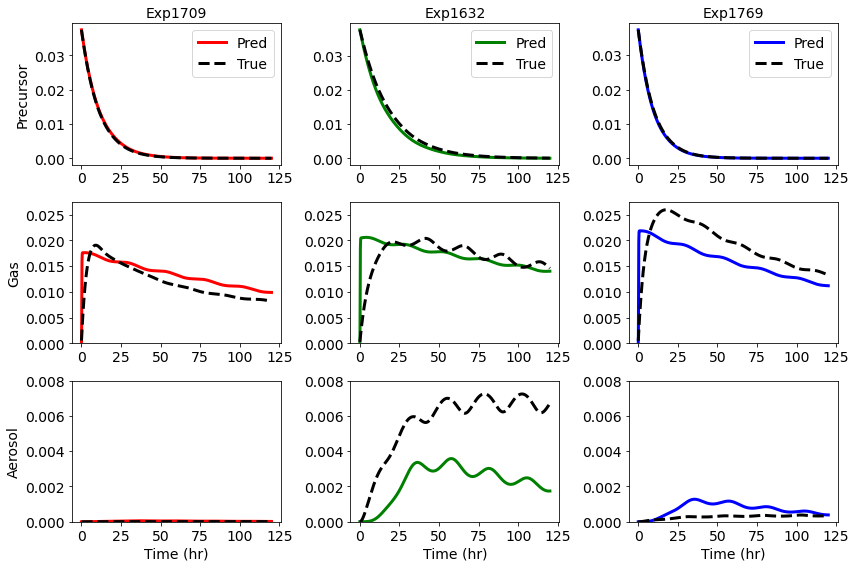

In [23]:
compare_models.plot(truth, preds, 14, prec_lim, gas_lim, aero_lim)

In [24]:
get_metrics(truth, preds)

Precursor [ug/m3] - R2: 1.00 Pearson: 1.00
Gas [ug/m3] - R2: 0.49 Pearson: 0.78
Aerosol [ug_m3] - R2: -0.12 Pearson: 0.69


{'Precursor [ug/m3]': [0.9999433238284727, 0.9999826286045355],
 'Gas [ug/m3]': [0.4898104763544905, 0.7814717788292421],
 'Aerosol [ug_m3]': [-0.11904222496056449, 0.6878774276665632]}

In [25]:
from sklearn.linear_model import Ridge
lin_model = Ridge(alpha= 200)
lin_model.fit(scaled_train_in, scaled_train_out)

Ridge(alpha=200)

In [26]:
lin_mae, truth, preds, failed_exps = compare_models.box_val(
    lin_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    output_vars, 
    val_out
)

100%|██████████| 1438/1438 [00:00<00:00, 14000.75it/s]


In [27]:
preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']] = y_scaler.inverse_transform(preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']])
preds = inverse_log_transform(preds, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'])
truth = inverse_log_transform(truth, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'])

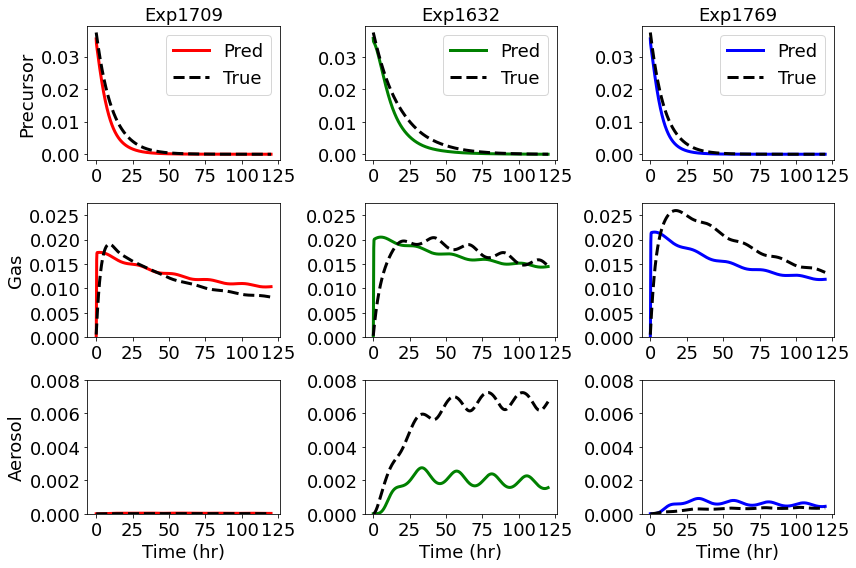

In [28]:
compare_models.plot(truth, preds, 18, prec_lim, gas_lim, aero_lim)

In [30]:
get_metrics(truth, preds)

Precursor [ug/m3] - R2: 0.94 Pearson: 0.99
Gas [ug/m3] - R2: 0.42 Pearson: 0.74
Aerosol [ug_m3] - R2: 0.33 Pearson: 0.61


{'Precursor [ug/m3]': [0.94100103548277, 0.9884366200811349],
 'Gas [ug/m3]': [0.4201617204799173, 0.7409172466930969],
 'Aerosol [ug_m3]': [0.3280024393217723, 0.6128654849345994]}

In [31]:
hyper_param_list = [x for x in range(0,400,25)]
prec_r2 = []
gas_r2 = []
aero_r2 = []

prec_pearson = []
gas_pearson = []
aero_pearson = []

In [32]:
for param in hyper_param_list:
    lin_model = Ridge(alpha= param)
    lin_model.fit(scaled_train_in, scaled_train_out)
    
    lin_mae, truth, preds, failed_exps = compare_models.box_val(
    lin_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    output_vars, 
    val_out)
    
    preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']] = y_scaler.inverse_transform(preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']])
    preds = inverse_log_transform(preds, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'])
    truth = inverse_log_transform(truth, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'])
    
    results = get_metrics(truth, preds)
    
    prec_r2.append(results['Precursor [ug/m3]'][0])
    aero_r2.append(results['Aerosol [ug_m3]'][0])
    gas_r2.append(results['Gas [ug/m3]'][0])
    
    prec_pearson.append(results['Precursor [ug/m3]'][1])
    aero_pearson.append(results['Aerosol [ug_m3]'][1])
    gas_pearson.append(results['Gas [ug/m3]'][1])

100%|██████████| 1438/1438 [00:00<00:00, 15729.53it/s]


Precursor [ug/m3] - R2: 1.00 Pearson: 1.00
Gas [ug/m3] - R2: 0.49 Pearson: 0.78
Aerosol [ug_m3] - R2: -0.12 Pearson: 0.69


100%|██████████| 1438/1438 [00:00<00:00, 15350.81it/s]


Precursor [ug/m3] - R2: 1.00 Pearson: 1.00
Gas [ug/m3] - R2: 0.49 Pearson: 0.78
Aerosol [ug_m3] - R2: 0.06 Pearson: 0.67


100%|██████████| 1438/1438 [00:00<00:00, 13974.21it/s]


Precursor [ug/m3] - R2: 1.00 Pearson: 1.00
Gas [ug/m3] - R2: 0.48 Pearson: 0.78
Aerosol [ug_m3] - R2: 0.16 Pearson: 0.66


100%|██████████| 1438/1438 [00:00<00:00, 15258.50it/s]


Precursor [ug/m3] - R2: 0.99 Pearson: 1.00
Gas [ug/m3] - R2: 0.47 Pearson: 0.77
Aerosol [ug_m3] - R2: 0.23 Pearson: 0.65


100%|██████████| 1438/1438 [00:00<00:00, 15302.05it/s]


Precursor [ug/m3] - R2: 0.98 Pearson: 1.00
Gas [ug/m3] - R2: 0.46 Pearson: 0.77
Aerosol [ug_m3] - R2: 0.27 Pearson: 0.64


100%|██████████| 1438/1438 [00:00<00:00, 15871.88it/s]


Precursor [ug/m3] - R2: 0.97 Pearson: 1.00
Gas [ug/m3] - R2: 0.45 Pearson: 0.76
Aerosol [ug_m3] - R2: 0.30 Pearson: 0.63


100%|██████████| 1438/1438 [00:00<00:00, 15584.79it/s]


Precursor [ug/m3] - R2: 0.96 Pearson: 0.99
Gas [ug/m3] - R2: 0.44 Pearson: 0.76
Aerosol [ug_m3] - R2: 0.31 Pearson: 0.62


100%|██████████| 1438/1438 [00:00<00:00, 15526.30it/s]


Precursor [ug/m3] - R2: 0.95 Pearson: 0.99
Gas [ug/m3] - R2: 0.43 Pearson: 0.75
Aerosol [ug_m3] - R2: 0.32 Pearson: 0.62


100%|██████████| 1438/1438 [00:00<00:00, 15436.97it/s]


Precursor [ug/m3] - R2: 0.94 Pearson: 0.99
Gas [ug/m3] - R2: 0.42 Pearson: 0.74
Aerosol [ug_m3] - R2: 0.33 Pearson: 0.61


100%|██████████| 1438/1438 [00:00<00:00, 15585.32it/s]


Precursor [ug/m3] - R2: 0.93 Pearson: 0.99
Gas [ug/m3] - R2: 0.41 Pearson: 0.73
Aerosol [ug_m3] - R2: 0.33 Pearson: 0.61


100%|██████████| 1438/1438 [00:00<00:00, 15365.55it/s]


Precursor [ug/m3] - R2: 0.92 Pearson: 0.98
Gas [ug/m3] - R2: 0.40 Pearson: 0.72
Aerosol [ug_m3] - R2: 0.33 Pearson: 0.60


100%|██████████| 1438/1438 [00:00<00:00, 15741.76it/s]


Precursor [ug/m3] - R2: 0.90 Pearson: 0.98
Gas [ug/m3] - R2: 0.38 Pearson: 0.72
Aerosol [ug_m3] - R2: 0.32 Pearson: 0.59


100%|██████████| 1438/1438 [00:00<00:00, 15747.72it/s]


Precursor [ug/m3] - R2: 0.89 Pearson: 0.98
Gas [ug/m3] - R2: 0.37 Pearson: 0.71
Aerosol [ug_m3] - R2: 0.31 Pearson: 0.59


100%|██████████| 1438/1438 [00:00<00:00, 15028.89it/s]


Precursor [ug/m3] - R2: 0.88 Pearson: 0.97
Gas [ug/m3] - R2: 0.36 Pearson: 0.70
Aerosol [ug_m3] - R2: 0.31 Pearson: 0.58


100%|██████████| 1438/1438 [00:00<00:00, 15263.05it/s]


Precursor [ug/m3] - R2: 0.86 Pearson: 0.97
Gas [ug/m3] - R2: 0.35 Pearson: 0.69
Aerosol [ug_m3] - R2: 0.30 Pearson: 0.57


100%|██████████| 1438/1438 [00:00<00:00, 15621.97it/s]


Precursor [ug/m3] - R2: 0.85 Pearson: 0.97
Gas [ug/m3] - R2: 0.34 Pearson: 0.68
Aerosol [ug_m3] - R2: 0.29 Pearson: 0.56


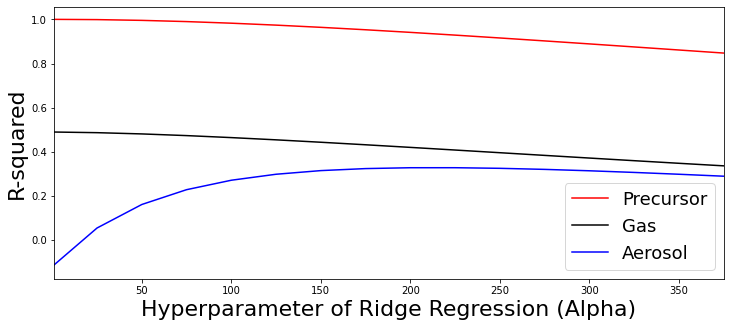

In [36]:
plt.figure(figsize=(12,5))


_ = plt.plot(hyper_param_list, prec_r2, color = 'red', label = "Precursor")

_ = plt.plot(hyper_param_list, gas_r2, color = 'black', label="Gas")

_ = plt.plot(hyper_param_list, aero_r2, color = 'blue', label="Aerosol")

plt.legend(loc='best', fontsize = 18)

plt.xlim(1,375,0.5)
plt.ylabel('R-squared', fontsize = 22)
plt.xlabel('Hyperparameter of Ridge Regression (Alpha)', fontsize = 22)

plt.savefig('./hyperparam.png')
plt.show()
plt.close()



# 10/20/2021

Finish above before moving on.

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor
n = 2
n_samples = scaled_train_in.shape[0]
rf_model = RandomForestRegressor(n_estimators=n)
rf_model.fit(scaled_train_in[:n_samples], scaled_train_out[:n_samples])

RandomForestRegressor(n_estimators=2)

In [39]:
lin_mae, truth, preds, failed_exps = compare_models.box_val(
    rf_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    output_vars, 
    val_out
)

100%|██████████| 1438/1438 [00:00<00:00, 1538.82it/s]


In [40]:
preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']] = y_scaler.inverse_transform(preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']])
preds = inverse_log_transform(preds, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'])
truth = inverse_log_transform(truth, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'])

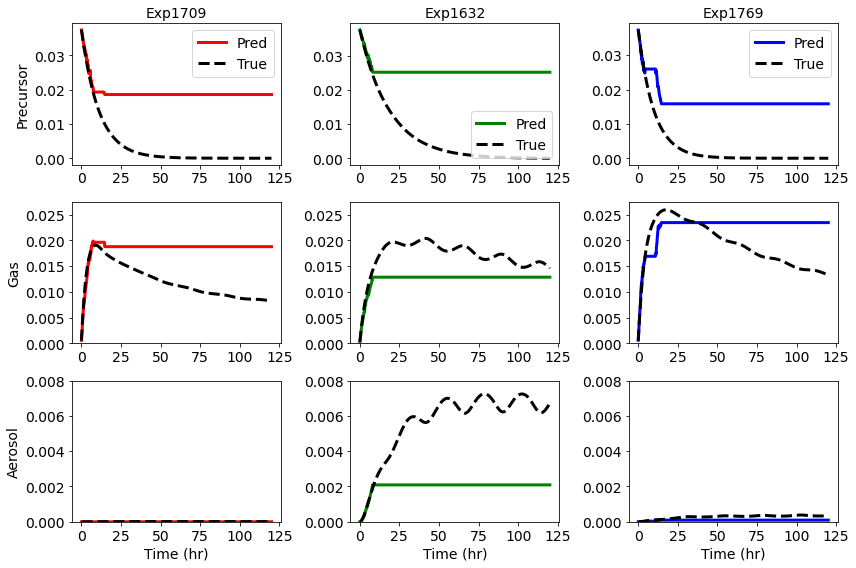

In [41]:
compare_models.plot(truth, preds, 14, prec_lim, gas_lim, aero_lim)

In [42]:
get_metrics()

TypeError: get_metrics() missing 2 required positional arguments: 'truth' and 'preds'

### DNN

In [43]:
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, Activation, \
    Concatenate, BatchNormalization, LSTM, Conv1D, AveragePooling1D, MaxPooling1D, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
import xarray as xr
import pandas as pd


class DenseNeuralNetwork(object):
    """
    A Dense Neural Network Model that can support arbitrary numbers of hidden layers.
    Attributes:
        hidden_layers: Number of hidden layers
        hidden_neurons: Number of neurons in each hidden layer
        activation: Type of activation function
        output_layers: Number of output layers (1, 2, or 3)
        output_activation: Activation function applied to the output layer
        optimizer: Name of optimizer or optimizer object.
        loss: Name of loss functions or loss objects (can match up to number of output layers)
        loss_weights: Weights to be assigned to respective loss/output layer
        use_noise: Whether or not additive Gaussian noise layers are included in the network
        noise_sd: The standard deviation of the Gaussian noise layers
        lr: Learning rate for optimizer
        use_dropout: Whether or not Dropout layers are added to the network
        dropout_alpha: proportion of neurons randomly set to 0.
        batch_size: Number of examples per batch
        epochs: Number of epochs to train
        l2_weight: L2 weight parameter
        sgd_momentum: SGD optimizer momentum parameter
        adam_beta_1: Adam optimizer beta_1 parameter
        adam_beta_2: Adam optimizer beta_2 parameter
        decay: Level of decay to apply to learning rate
        verbose: Level of detail to provide during training (0 = None, 1 = Minimal, 2 = All)
        classifier: (boolean) If training on classes
    """
    def __init__(self, hidden_layers=1, hidden_neurons=4, activation="relu", output_layers=1,
                 output_activation="linear", optimizer="adam", loss="mse", loss_weights=1, use_noise=False,
                 noise_sd=0.01, lr=0.001, use_dropout=False, dropout_alpha=0.1, batch_size=128, epochs=2,
                 kernel_reg='l2', l1_weight=0.01, l2_weight=0.01, sgd_momentum=0.9, adam_beta_1=0.9, adam_beta_2=0.999,
                 epsilon=1e-7, decay=0, verbose=0, classifier=False):
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.activation = activation
        self.output_layers = output_layers
        self.output_activation = output_activation
        self.optimizer = optimizer
        self.optimizer_obj = None
        self.sgd_momentum = sgd_momentum
        self.adam_beta_1 = adam_beta_1
        self.adam_beta_2 = adam_beta_2
        self.epsilon = epsilon
        self.loss = loss
        self.loss_weights = loss_weights
        self.lr = lr
        self.kernel_reg = kernel_reg
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.batch_size = batch_size
        self.use_noise = use_noise
        self.noise_sd = noise_sd
        self.use_dropout = use_dropout
        self.dropout_alpha = dropout_alpha
        self.epochs = epochs
        self.decay = decay
        self.verbose = verbose
        self.classifier = classifier
        self.y_labels = None
        self.model = None

    def x_sigmoid(self, y_actual, y_pred):
        x = y_actual - y_pred
        custom_loss = K.mean(2 * x / (1 + K.exp(-x)) - x)
        return custom_loss

    def build_neural_network(self, inputs, outputs):
        """
        Create Keras neural network model and compile it.
        Args:
            inputs (int): Number of input predictor variables
            outputs (int): Number of output predictor variables
        """
        nn_input = Input(shape=(inputs,), name="input")
        nn_model = nn_input
        if self.activation == 'leaky':
            self.activation = LeakyReLU()

        if self.kernel_reg == 'l1':
            self.kernel_reg = l1(self.l1_weight)
        elif self.kernel_reg == 'l2':
            self.kernel_reg = l2(self.l2_weight)
        elif self.kernel_reg == 'l1_l2':
            self.kernel_reg = l1_l2(self.l1_weight, self.l2_weight)
        else:
            self.kernel_reg = None

        for h in range(self.hidden_layers):
            nn_model = Dense(self.hidden_neurons, activation=self.activation,
                             kernel_regularizer=self.kernel_reg, name=f"dense_{h:02d}")(nn_model)
            if self.use_dropout:
                nn_model = Dropout(self.dropout_alpha, name=f"dropout_h_{h:02d}")(nn_model)
            if self.use_noise:
                nn_model = GaussianNoise(self.noise_sd, name=f"ganoise_h_{h:02d}")(nn_model)
        nn_model_out = {}
        for i in range(len(outputs)):
            nn_model_out[i] = Dense(outputs[i],
                             activation=self.output_activation, name=f"dense_out_{i:02d}")(nn_model)
        output_layers = [x for x in nn_model_out.values()]
        self.model = Model(nn_input, output_layers)
        if self.optimizer == "adam":
            self.optimizer_obj = Adam(lr=self.lr, beta_1=self.adam_beta_1, beta_2=self.adam_beta_2,
                                      epsilon=self.epsilon, decay=self.decay)
        elif self.optimizer == "sgd":
            self.optimizer_obj = SGD(lr=self.lr, momentum=self.sgd_momentum, decay=self.decay)

        if self.loss == 'Xsigmoid':
            self.model.compile(optimizer=self.optimizer_obj, loss=self.x_sigmoid, loss_weights=self.loss_weights)
        else:
            self.model.compile(optimizer=self.optimizer_obj, loss=self.loss, loss_weights=self.loss_weights)


    def fit(self, x, y):
        inputs = x.shape[1]
        outputs = [i.shape[-1] for i in y]
        if self.classifier:
            outputs = np.unique(y).size
        self.build_neural_network(inputs, outputs)
        if self.classifier:
            self.y_labels = np.unique(y)
            y_class = np.zeros((y.shape[0], self.y_labels.size), dtype=np.int32)
            for l, label in enumerate(self.y_labels):
                y_class[y == label, l] = 1
            self.model.fit(x, y_class, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose)
        else:
            self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose, shuffle=True)
            print(self.model.summary())
        return

    def save_fortran_model(self, filename):

        nn_ds = xr.Dataset()
        num_dense, num_dense_out = 0, 0
        layer_names, out_bias, out_weights = [], [], []

        for layer in self.model.layers:

            if "dense" in layer.name and "out" not in layer.name:
                layer_names.append(layer.name)
                dense_weights = layer.get_weights()
                nn_ds[layer.name + "_weights"] = ((layer.name + "_in", layer.name + "_out"), dense_weights[0])
                nn_ds[layer.name + "_bias"] = ((layer.name + "_out",), dense_weights[1])
                nn_ds[layer.name + "_weights"].attrs["name"] = layer.name
                nn_ds[layer.name + "_weights"].attrs["activation"] = str(layer.get_config()["activation"])
                num_dense += 1

            elif "dense" in layer.name and "out" in layer.name:
                dense_weights = layer.get_weights()
                out_weights.append(dense_weights[0])
                out_bias.append(dense_weights[1])
                num_dense_out += 1

        layer_names.append(self.model.layers[-num_dense_out].name)
        concatenated_weights = np.concatenate(out_weights, axis=1)
        concatenated_bias = np.concatenate(out_bias)
        nn_ds[self.model.layers[-num_dense_out].name + "_weights"] = (
            (self.model.layers[-num_dense_out].name + "_in", self.model.layers[-num_dense_out].name + "_out"),
            concatenated_weights)
        nn_ds[self.model.layers[-num_dense_out].name + "_bias"] = (
            (self.model.layers[-num_dense_out].name + "_out",), concatenated_bias)
        nn_ds[self.model.layers[-num_dense_out].name + "_weights"].attrs["name"] = \
            self.model.layers[-num_dense_out].name
        nn_ds[self.model.layers[-num_dense_out].name + "_weights"].attrs["activation"] = \
            self.model.layers[-num_dense_out].get_config()["activation"]
        num_dense += 1
        nn_ds["layer_names"] = (("num_layers",), np.array(layer_names))
        nn_ds.attrs["num_layers"] = num_dense
        nn_ds.to_netcdf(filename, encoding={'layer_names': {'dtype': 'S1'}})
        return nn_ds

    def predict(self, x):
        if self.classifier:
            y_prob = self.model.predict(x, batch_size=self.batch_size)
            y_out = self.y_labels[np.argmax(y_prob, axis=1)]
        else:
            y_out = np.block(self.model.predict(x, batch_size=self.batch_size))
        return y_out

    def predict_proba(self, x):
        y_prob = self.model.predict(x, batch_size=self.batch_size)
        return y_prob


In [44]:
!pip install keras-self-attention

Defaulting to user installation because normal site-packages is not writeable


In [45]:
NN_model = DenseNeuralNetwork(hidden_neurons=100, l2_weight=1e-8, verbose=1, epochs=20)

In [46]:
scaled_train_in

array([[ 1.        , -1.        , -1.        , ...,  0.17630012,
        -0.62793337, -0.27607498],
       [ 0.9995556 ,  0.6484798 , -0.7102759 , ...,  0.17630012,
        -0.62793337, -0.27607498],
       [ 0.99911105,  0.70501327, -0.59492211, ...,  0.17630012,
        -0.62793337, -0.27607498],
       ...,
       [-0.34578246,  0.83381522,  0.77629214, ..., -0.83415967,
        -0.57241302,  0.42994696],
       [-0.34671818,  0.83353673,  0.77707806, ..., -0.83415967,
        -0.57241302,  0.42994696],
       [-0.3476543 ,  0.83325575,  0.77786279, ..., -0.83415967,
        -0.57241302,  0.42994696]])

In [47]:
scaled_train_in.shape

(2302400, 9)

In [48]:
NN_model.fit(scaled_train_in, [scaled_train_out])

Epoch 1/20
17988/17988 [==============================] - 14s 701us/step - loss: 7.8480e-04
Epoch 2/20
17988/17988 [==============================] - 13s 723us/step - loss: 1.0089e-05
Epoch 3/20
17988/17988 [==============================] - 12s 667us/step - loss: 7.9895e-06
Epoch 4/20
17988/17988 [==============================] - 12s 678us/step - loss: 7.1420e-06
Epoch 5/20
17988/17988 [==============================] - 12s 669us/step - loss: 6.7108e-06
Epoch 6/20
17988/17988 [==============================] - 12s 668us/step - loss: 6.3850e-06
Epoch 7/20
17988/17988 [==============================] - 12s 665us/step - loss: 6.1130e-06
Epoch 8/20
17988/17988 [==============================] - 12s 671us/step - loss: 5.8552e-06
Epoch 9/20
17988/17988 [==============================] - 12s 670us/step - loss: 5.6861e-06
Epoch 10/20
17988/17988 [==============================] - 12s 669us/step - loss: 5.4554e-06
Epoch 11/20
17988/17988 [==============================] - 12s 668us/step - los

In [49]:
nn_mae, truth, preds, failed_exps = compare_models.box_val(
    NN_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    output_vars, 
    val_out
)

100%|██████████| 1438/1438 [00:46<00:00, 30.70it/s]


In [50]:
preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']] = y_scaler.inverse_transform(preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']])
preds = inverse_log_transform(preds, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'])
truth = inverse_log_transform(truth, ['Precursor [ug/m3]', 'Aerosol [ug_m3]', 'Gas [ug/m3]'])

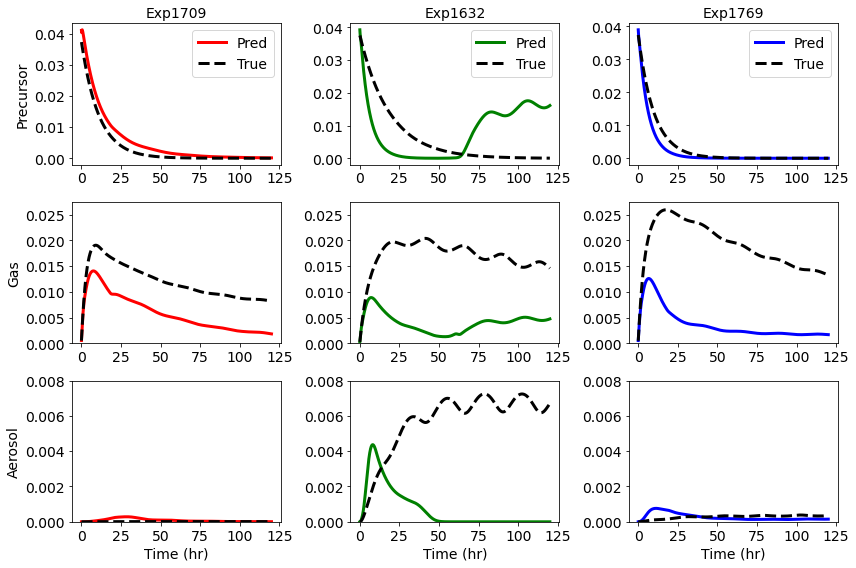

In [51]:
compare_models.plot(truth, preds, 14, prec_lim, gas_lim, aero_lim)

In [52]:
get_metrics(truth,preds)

Precursor [ug/m3] - R2: 1.00 Pearson: 1.00
Gas [ug/m3] - R2: -3.65 Pearson: 0.82
Aerosol [ug_m3] - R2: -23.06 Pearson: -0.30


{'Precursor [ug/m3]': [0.9960097421995883, 0.9980235539131624],
 'Gas [ug/m3]': [-3.6450128390458962, 0.824010127670567],
 'Aerosol [ug_m3]': [-23.058435792971427, -0.2973851103515697]}

### Training, validation, and testing sets
This training dataset/library consists of 2000 GECKO experiments, including results for 5 day runs (1440 timesteps at 300 second intervals). The data has already been split into training/validation/test sets by random expiriments of size 1400/200/200 (and 200 for a hidden test set). Thus, the training set consists of 2,016,000 samples of data and test/validation sets with 288,000 samples.

**Show transformation that's already in compare notebooks**

In [53]:
# Extract config arguments and validate if necessary
species = config['species']
dir_path = config['dir_path']
summary_file = config['summary_file']
aggregate_bins = config['aggregate_bins']
bin_prefix = config['bin_prefix']
input_vars = config['input_vars']
output_vars = config['output_vars']
output_path = config['output_path']
scaler_type = config['scaler_type']
seq_length = config['seq_length']
ensemble_members = config["ensemble_members"]
seed = config['random_seed']
# tf.random.set_seed(seed)

for folder in ['models', 'plots', 'validation_data', 'metrics', 'scalers']:
    os.makedirs(join(output_path, folder), exist_ok=True)

# Load GECKO experiment data, split into ML inputs and outputs and persistence outputs
input_data, output_data = combine_data(dir_path, summary_file, aggregate_bins, bin_prefix,
                                       input_vars, output_vars, species)

# Split into training, validation, testing subsets
in_train, out_train, in_val, out_val, in_test, out_test = split_data(
                                                                input_data=input_data, 
                                                                output_data=output_data, 
                                                                train_start=config['train_start_exp'],
                                                                train_end=config['train_end_exp'],
                                                                val_start=config['val_start_exp'],
                                                                val_end=config['val_end_exp'],
                                                                test_start=config['test_start_exp'],
                                                                test_end=config['test_end_exp'])

num_timesteps = in_train['Time [s]'].nunique()

# Rescale training and validation / testing data
x_scaler = scalers[scaler_type]((config['min_scale_range'], config['max_scale_range']))
scaled_in_train = x_scaler.fit_transform(in_train.drop(['Time [s]', 'id'], axis=1))
scaled_in_val = x_scaler.transform(in_val.drop(['Time [s]', 'id'], axis=1))

y_scaler = get_output_scaler(x_scaler, output_vars, scaler_type, data_range=(
                            config['min_scale_range'], config['max_scale_range']))
scaled_out_train = y_scaler.transform(out_train.drop(['Time [s]', 'id'], axis=1))
scaled_out_val = y_scaler.transform(out_val.drop(['Time [s]', 'id'], axis=1))

scaled_in_train_ts, scaled_out_train_ts = reshape_data(scaled_in_train.copy(), scaled_out_train.copy(),
                                                       seq_length, num_timesteps)
scaled_in_val_ts, scaled_out_val_ts = reshape_data(scaled_in_val.copy(), scaled_out_val.copy(),
                                                   seq_length, num_timesteps)


NameError: name 'config' is not defined

In [ ]:
# Batch the training experiments 
#logging.info("Batching the training data by experiment, this may take a few minutes")
def work(exp):
    in_data = x_scaler.transform(in_train[in_train['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))
train_exps = list(in_train['id'].unique())
with mp.Pool(processes=16) as p:
    in_array, env_array = zip(*[result for result in tqdm.tqdm(p.imap(work, train_exps), total=len(train_exps))])
#in_array, env_array = zip(*[work(x) for x in train_exps])
in_array = np.concatenate(in_array) # (num_experiments, num_timesteps, outputs)
env_array = np.concatenate(env_array)

In [ ]:
#logging.info("Batching the validation data by experiment")
def work(exp):
    in_data = x_scaler.transform(in_val[in_val['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))
val_exps = list(in_val['id'].unique())
val_in_array, val_env_array = zip(*[work(x) for x in tqdm.tqdm(val_exps)])
val_in_array = np.concatenate(val_in_array) # (num_experiments, num_timesteps, outputs)
val_env_array = np.concatenate(val_env_array)

In [ ]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(scaled_in_train, scaled_out_train)

In [ ]:
lin_mae, truth, preds, failed_exps = compare_models.box_val(
    lin_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    output_vars, 
    out_val
)

In [ ]:
preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']] = y_scaler.inverse_transform(preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']])
preds[['Precursor [ug/m3]']] = 10**preds[["Precursor [ug/m3]"]]
truth[['Precursor [ug/m3]']] = 10**truth[["Precursor [ug/m3]"]]

In [ ]:
compare_models.plot(truth, preds, fontsize, prec_lim, gas_lim, aero_lim)

In [ ]:
metrics(truth, preds)

**Show change in modifying hyperparameter **

In [ ]:
from sklearn.linear_model import Ridge
lin_model = Ridge(alpha= 600.0)
lin_model.fit(scaled_in_train, scaled_out_train)

In [ ]:
lin_mae, truth, preds, failed_exps = compare_models.box_val(
    lin_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    output_vars, 
    out_val
)

In [ ]:
preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']] = y_scaler.inverse_transform(preds[[ 'Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']])
preds[['Precursor [ug/m3]']] = 10**preds[["Precursor [ug/m3]"]]
truth[['Precursor [ug/m3]']] = 10**truth[["Precursor [ug/m3]"]]

In [ ]:
compare_models.plot(truth, preds, fontsize, prec_lim, gas_lim, aero_lim)

In [ ]:
metrics(truth, preds)

## Keras

In [ ]:
# toluene
tolu_keras_mlp = "/glade/work/keelyl/geckonew/gecko-ml/toluene_agg_runs_unvaried/4_27_models/toluene_dnn_1_6/"
tolu_torch_rnn = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/toluene/6/best.pt"

# apin
apin_keras_mlp = "/glade/work/keelyl/geckonew/gecko-ml/apin_agg_runs/05_14_models/apin_O3_dnn_1_2/"
apin_torch_rnn = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/apin/7/best.pt"


# dodecane
dode_keras_mlp = "/glade/work/keelyl/geckonew/gecko-ml/dodecane_agg_runs/05_06_models/dodecane_dnn_1_6/"
dode_torch_rnn = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/dodecane/3/best.pt"

In [ ]:
if species == "toluene":
    keras_mlp = tolu_keras_mlp
    torch_rnn = tolu_torch_rnn
    prec_lim = 0.05
    gas_lim = 0.0275
    aero_lim = 0.008
elif species == "dodecane":
    keras_mlp = dode_keras_mlp
    torch_rnn = dode_torch_rnn
    prec_lim = 0.075
    gas_lim = 0.1
    aero_lim = 0.08
else:
    keras_mlp = apin_keras_mlp
    torch_rnn = apin_torch_rnn
    prec_lim = 0.075
    gas_lim = 0.1
    aero_lim = 0.07
    
fontsize = 14